<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/AdaptiveMidpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

import sympy as sp


clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [3]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

Load pre-defined functions from GitHub


# Working on the mesh

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


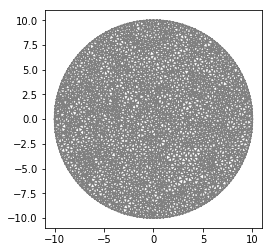

In [4]:
'''
geo_choice = 1
if geo_choice == 1:
    mesh_file = "fru_M_100383_1D.xml"
else:    
    mesh_file = "fru_M_100383_3D.xml"
mesh_file_exists = os.path.isfile(mesh_file)
if (mesh_file_exists==False):
    !wget https://github.com/van-dang/MRI-Cloud/raw/mesh/$mesh_file''.zip  
    !unzip -q $mesh_file''.zip
mymesh = Mesh(mesh_file);
'''

domain = Circle(Point(0,0), 10)
r = 30   # Resolution of mesh
mymesh = generate_mesh(domain, r)
plot(mymesh)


# Solve the Bloch-Torrey equation

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
t:   0.00  T: 20000.00 dt: 100.0 qvalue: 1.224745e-04 Completed 0.00%
t: 10000.00  T: 20000.00 dt: 100.0 qvalue: 1.224745e-04 Completed 49.75%


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


t: 20000.00  T: 20000.00 dt: 100.0 qvalue: 1.224745e-04 Completed 99.50%
Successfully Completed! Elapsed time: 4.389235 seconds
b: 10000.000, g: 0.458, q: 1.225e-04, Signal: 2.550e+00, Normalized signal: 8.123e-03, dt: 100.000, hmin: 3.471e-01, whole_vol: 313.925, vol_of_interest: 313.925, Free signal: 9.358e-14, elasped time 4.389 (s)

save to log.txt


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


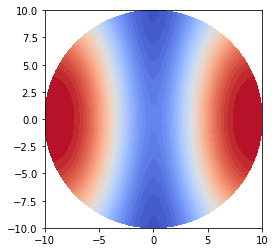

In [16]:
from scipy.integrate import ode

mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [10000]
signal_array=[];
voi_array=[];
whole_vol_array = [];

def compute_est(theta, u_L, u_H):
    """Return error estimate by Richardson extrapolation"""
    p = 2 if theta == 0.5 else 1
    est = sqrt(assemble((u_L - u_H)**2*dx)) / (2**p - 1)
    return est

def compute_new_dt(theta, est, tol, dt):
    """Return new time step"""
    p = 2 if theta == 0.5 else 1
    rho = 0.9
    dt_new = dt * ( rho * tol / est )**(1/p)
    return dt_new

def ThetaMethodF1(ft, ift, mri_para, mri_simu, w, v, mydomain):
    if (mydomain.IsDomainMultiple==True):
      if (mydomain.IsDomainPeriodic==True) and sum(mydomain.PeriodicDir)>0:
          F = ThetaMethodF_sBC2c(ft, ift, mri_para, w, v, mri_simu, mydomain)
      else:
          F = ThetaMethodF_wBC2c(ft, ift, mri_para, w, v, mri_simu, mydomain)
    else:
      if (mydomain.IsDomainPeriodic==True) and sum(mydomain.PeriodicDir)>0:
          F = ThetaMethodF_sBC1c(ft, ift, mri_para, w, v, mri_simu, mydomain)
      else:
          F = ThetaMethodF_wBC1c(ft, ift, mri_para, w, v, mri_simu, mydomain)
    return F  

def mid_point_single_step(tp, t, dt, w0):
    ft_prev = mri_para.time_profile(tp);
    ift_prev = mri_para.itime_profile(tp);
    ft = mri_para.time_profile(t);
    ift = mri_para.itime_profile(t);
    A = 1/dt*M + assemble(ThetaMethodF1(ft, ift, mri_para, mri_simu, w, v, mydomain))
    b = 1/dt*M*w0.vector() - assemble(ThetaMethodF1(ft_prev, ift_prev, mri_para, mri_simu, w0, v, mydomain))
    w1 =  Function(mydomain.W);
    linsolver.solve(A, w1.vector(),b);
    return w1

  
for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.stype='PGSE'                                # sequence type
    mri_para.bvalue = bvalue;                              # bvalue
    mri_para.delta, mri_para.Delta = 10000, 10000        # time sequence
    mri_para.set_gradient_dir(mymesh, 1, 0, 0)           # gradient direction

    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 


    mri_para.Apply()
    mri_simu.k = 100;                                    # time-step size
    mri_simu.nskip = 100;                                  # frequency to print ouputs
    mydomain = MyDomain(mymesh, mri_para)
    mydomain.phase = None
    mydomain.PeriodicDir = [0, 0, 0];             # Direction of the periodicity
    mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
    ################################################################################
    mydomain.Apply()   # Call Apply before setting the diffusion tensor
    ################################################################################
    # Impose the diffusion coefficient
    mydomain.D0 = 3e-3
    mydomain.D = mydomain.D0;
    #################################################################################

    # linsolver = PETScLUSolver("mumps")
    linsolver = KrylovSolver("bicgstab")

    # mri_simu.solve(mydomain, mri_para, linsolver)

    mri_simu.Dirac_Delta, w0 = mri_simu.InitialCondition(mydomain, None)

    stepcounter = 0;

    M = MassMatrix(mydomain);
    
    mri_simu.t = 0;
    tp = 0;
    #ft_prev  =  mri_para.time_profile(mri_simu.t);
    #ift_prev = mri_para.itime_profile(mri_simu.t);

    v = TestFunction(mydomain.W); w = TrialFunction(mydomain.W);

    ###### 
    import numpy as np
    mass_form = (w[0]*v[0]+w[1]*v[1])*dx

    mass_action_form = action(mass_form, Constant((1,1)))

    M_lumped = assemble(mass_form)
    M_lumped.zero()

    b=assemble(mass_action_form)
    b_inv = Vector(b)
    b_inv[:] = np.divide(1,b[:])

    M_lumped.set_diagonal(b_inv)

    ######
    
    start_time = time.time()
  
    def f(t, u0, Minv):
        w0 = Function(mydomain.W)
        w0.vector()[:] = u0
        ft = mri_para.time_profile(t);
        ift = mri_para.itime_profile(t);
        rhs = -2*assemble(ThetaMethodF1(ft, ift, mri_para, mri_simu, w0, v, mydomain))  
        #b = Vector()
        #linsolver.solve(M, b, rhs)
        b = np.dot(Minv, rhs)
        return b
    def jac(t, u0, Minv):
        ft = mri_para.time_profile(t);
        ift = mri_para.itime_profile(t);
        w = TrialFunction(mydomain.W)
        J = -2*assemble(ThetaMethodF1(ft, ift, mri_para, mri_simu, w, v, mydomain)) 
        J = np.multiply(Minv, J.array())
        return J
    
    t0 = 0
    
    # backend = 'dopri5'
    #backend = 'dop853'

    # ode15s = ode(f, jac).set_integrator('vode', method='bdf', order=15)
    
    #print(w0.vector()[:])
    #from scipy.integrate import solve_ivp
    #from scipy.integrate import odeint
    #tarry = np.linspace(t0, mri_para.T, 10)
    #sol = odeint(f, w0.vector()[:], tarry, Dfun=jac, rtol=1e-3, atol=1e-3)
    #print(tarry)
    #sol = odeint(f, w0.vector()[:], tarry, Dfun=jac)
    #print(sol.y)
    
    ode15s = ode(f, jac).set_integrator('vode', rtol=1e-5, atol=1e-5, method='bdf', with_jacobian=True, order=15)
    ode15s.set_initial_value(w0.vector(), t0).set_f_params(M_lumped.array()).set_jac_params(M_lumped.array())

    start_time = time.time()
    # tarray=[t0];
    
    if 1==2:
        num_steps = 0;
        tp = 0;
        #while ode15s.successful() and ode15s.t <= mri_para.T :
        #    ode15s.integrate(mri_para.T, step=True) 
        #    print(ode15s.t-tp, ode15s.t)
        #    tp = ode15s.t
            
        while ode15s.successful() and ode15s.t <= mri_para.T:
            ode15s.integrate(ode15s.t + mri_simu.k)
            # u.append(ode15s.y);  t.append(ode15s.t)
            print(ode15s.t-tp, ode15s.t)
            tp = ode15s.t
    
        w0.vector()[:] = ode15s.y
    else:
        while mri_simu.t < mri_para.T + mri_simu.k: # Time-stepping loop
            if stepcounter % mri_simu.nskip == 0:
                print('t: %6.2f '%mri_simu.t, 'T: %6.2f'%mri_para.T, 'dt: %.1f'%mri_simu.k,'qvalue: %e'%mri_para.qvalue,'Completed %3.2f%%'%(float(mri_simu.t)/float(mri_para.T+mri_simu.k)*100.0));
            if 1==2:
                u_low  = mid_point_single_step(tp, mri_simu.t, mri_simu.k,     w0);
                u_mid  = mid_point_single_step(tp, tp + 0.5*(mri_simu.t-tp), mri_simu.k/2, w0);
                u_high = mid_point_single_step( tp + 0.5*(mri_simu.t-tp), mri_simu.t, mri_simu.k/2,   u_mid);

                theta = 0.5
                tol = 1e-5
                est = compute_est(theta, u_low, u_high)
                dt_new = compute_new_dt(theta, est, tol, mri_simu.k)
                mri_simu.k = min(dt_new, mri_para.T - mri_simu.t)
                if est > tol:
                    mri_simu.k = min(dt_new, mri_para.T - mri_simu.t)
                    continue
                else: 
                  tp = mri_simu.t
                  w0.vector()[:] = u_high.vector()[:]
                  mri_simu.t += mri_simu.k;
            else: # midpoint
                u_low  = mid_point_single_step(tp, mri_simu.t, mri_simu.k,     w0);
                w0.vector()[:] = u_low.vector()[:]
                tp = mri_simu.t
                mri_simu.t += mri_simu.k;
                stepcounter += 1;
    
    
    mri_simu.elapsed_time = time.time() - start_time
    print("Successfully Completed! Elapsed time: %f seconds"%mri_simu.elapsed_time)   
    
    # Post-processing
    one = Function(mydomain.V)
    one.vector()[:] = 1
    whole_vol = assemble(one*dx)
    voi = assemble(mri_simu.Dirac_Delta*dx)
    if mydomain.IsDomainMultiple == True:
        u0r_0, u0i_0, u1r_0, u1i_0 = split(w0)
        initial0 = assemble((1-mydomain.phase)*mri_simu.Dirac_Delta*dx);
        signal0 = assemble(((1-mydomain.phase)*u0r_0)*dx);
        initial1 = assemble(mydomain.phase*mri_simu.Dirac_Delta*dx)
        signal1 = assemble((mydomain.phase*u1r_0)*dx);
        signal = assemble((mydomain.phase*u1r_0+(1-mydomain.phase)*u0r_0)*dx);
        print('Signal on each compartment')
        print('Sum initial0: %.3e, Signal0: %.3e'%(initial0, signal0))
        print('Sum initial1: %.3e, Signal1: %.3e'%(initial1, signal1))
        out_text = 'b: %.3f, g: %.3f, q: %.3e, Signal: %.3e, Normalized signal: %.3e, kappa: %.3e, dt: %.3f, hmin: %.3f, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, mri_para.gvalue, mri_para.qvalue, signal, signal/voi, mydomain.kappa, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*mydomain.D0), mri_simu.elapsed_time)
        print(out_text)
        V0 = FunctionSpace(mydomain.mesh0, mydomain.Ve);
        V1 = FunctionSpace(mydomain.mesh1, mydomain.Ve);
        u0r_0p = project(u0r_0,V0)
        u1r_0p = project(u1r_0,V1)
        if mydomain.tdim==mydomain.gdim and not(plt==None):
            plt.figure(10000);
            plot(u0r_0p, cmap="coolwarm")
            plt.figure(10001);            
            plot(u1r_0p, cmap="coolwarm")  
        File("u0r.pvd")<<u0r_0p
        File("u1r.pvd")<<u1r_0p
    else:
        ur, ui = split(w0)
        signal = assemble(ur*dx);
        out_text = 'b: %.3f, g: %.3f, q: %.3e, Signal: %.3e, Normalized signal: %.3e, dt: %.3f, hmin: %.3e, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, mri_para.gvalue, mri_para.qvalue, signal, signal/voi, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*mydomain.D0), mri_simu.elapsed_time)
        print(out_text)
        V = FunctionSpace(mydomain.mymesh,mydomain.Ve);
        ur_p = project(ur,V)
        if mydomain.tdim==mydomain.gdim and not(plt==None): 
            plt.figure(10000);
            plot(ur_p, cmap="coolwarm")
        File("ur.pvd")<<ur_p
    signal_array.append(signal)
    voi_array.append(voi)
    whole_vol_array.append(whole_vol);
    
    comm = MPI.comm_world
    rank = comm.Get_rank()    
    
    print("save to log.txt")
    outfile = open('log.txt', 'a')
    if int(rank) == 0:
            outfile.write(out_text)
    outfile.close()  

In [11]:
def f(t, u):
    return [u[1], 3.*(1. - u[0]*u[0])*u[1] - u[0]]

from scipy.integrate import ode
r = ode(f).set_integrator('vode', method='bdf', order=15, rtol=1e-6, atol=1e-6, with_jacobian=False)
u0 = [2.0, 0.0]
r.set_initial_value(u0, 0)
T = 30
dt = T/150.
u = [];  t = []
while r.successful() and r.t <= T:
    r.integrate(r.t + dt)
    u.append(r.y);  t.append(r.t)
    print(r.t)

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4
1.5999999999999999
1.7999999999999998
1.9999999999999998
2.1999999999999997
2.4
2.6
2.8000000000000003
3.0000000000000004
3.2000000000000006
3.400000000000001
3.600000000000001
3.800000000000001
4.000000000000001
4.200000000000001
4.400000000000001
4.600000000000001
4.800000000000002
5.000000000000002
5.200000000000002
5.400000000000002
5.600000000000002
5.8000000000000025
6.000000000000003
6.200000000000003
6.400000000000003
6.600000000000003
6.800000000000003
7.0000000000000036
7.200000000000004
7.400000000000004
7.600000000000004
7.800000000000004
8.000000000000004
8.200000000000003
8.400000000000002
8.600000000000001
8.8
9.0
9.2
9.399999999999999
9.599999999999998
9.799999999999997
9.999999999999996
10.199999999999996
10.399999999999995
10.599999999999994
10.799999999999994
10.999999999999993
11.199999999999992
11.399999999999991
11.59999999999999
11.79999999999999
11.99999999999999
12.199999999999989
12.399999999999988
12.599999999999987
